In [168]:
import pandas as pd
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
from datetime import datetime, date

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

import seaborn as sns

# Functions used throughout notebook

### Function below determines the number of days to reach GDDthreshold. Computes GDDs using input base temperature and daily Tmean array

In [169]:
# Function to compute day on which reach given growth stage.
# Compuate daily GDD given input Tmean temperature numpy array and upper temperature (scalar)
# Accumulates these and determines the date on which growth stage is met by comparing to GDDthresh
# Outputs S - the number of days to reach  growth stage
def getDaysToStage(Tmean,Tmax,Tmin,Tupp,GDDthresh):
    
    # Number of days to get to given growth stage
    S = len(Tmean)
    
    # Cumulative GDD variable (will be NGDD)
    NGDD = 0
    
    # Iterate through each day, add to  NGDD
    for d in range(S):
        curr_GDD = max(Tmean[d],60) - 60
        
        if Tmax[d] > Tupp:
            curr_GDD = max(((Tupp+Tmin[d])/2),60) - 60
        
        NGDD = NGDD + curr_GDD
        if(NGDD > GDDthresh):
            return(d)
    
    # If get here, means we never returned a number, in which case, return nan
    return(np.nan)

### Function takes dataframe with optimal Tupp and associated GDD requirements for each growth stage, calculates the predicted date at which each growth stage would occur using test data and compare with observed data.

In [170]:
# Block does same as block above, but this time making more dynamic -- so can test for 
# different Tupps

## Things we need:
# tupp_best_df = optimal Tupp dataframe. Expects columns: Cultivar	Stage	Tupp	GDD_Threshold	stage_num
# test_data = growth_pd[growth_pd['test_train']==0].copy()
# wx_data = wxdf
# run_type = 'from_plant' for runs that have accumulations/tupp to each stage that accrue from plant date, or
#          = 'each' for runs that start from previous stage
def getPredObs_DaysToStage(tupp_best_df,test_data,wx_data,run_type):

    test_data.set_index(['loc_id','cultivar','plot'],inplace=True)

    # Output 
    vald_arr = []

    # Iterate through each location-cultivar-plot
    for i in set(test_data.index):
        curr_growth = test_data.loc[i].copy()

        # Current loc_id
        curr_loc = list(i)[0]

        # Current cultivar
        curr_cult = list(i)[1]

        # Current plot:
        curr_plot = list(i)[2]


        # Get weather data associated with this location (will be used for all plots at this location)
        curr_wx = wx_data[wx_data['loc_id']==curr_loc]

        # Get plant date
        plant_day_of_year = curr_growth[curr_growth['stage_num']==1]['day_of_year_stage'].values[0] - \
                            curr_growth[curr_growth['stage_num']==1]['elapse_days'].values[0]

        # Iterate through stages (use stage_num, since is numeric); (loop ends at 7 -- means will evaluate 1-6)
        for s in range(1,7):

            # Current tupp
            curr_tupp = tupp_best_df[(tupp_best_df['Cultivar']==curr_cult) &
                                                (tupp_best_df['stage_num']==s)]['Tupp'].values[0]

            # Number of accumulated GDD to reach stage
            curr_ngdd = tupp_best_df[(tupp_best_df['Cultivar']==curr_cult) &
                                              (tupp_best_df['stage_num']==s)]['GDD_Threshold'].values[0]


            # Get date of current stage, if exists
            stage_day = curr_growth[curr_growth['stage_num']==s]['day_of_year_stage'].values
            if len(stage_day) > 0:
                stage_day_of_year = stage_day[0]
            else:
                stage_day_of_year = np.nan

                
            # If doing from Plant Date:
            if run_type=='from_plant':
                
                # Create df with just growing season data, compute GDD using tupp, then cumusm and compare to gdd reqs
                wx_plot = curr_wx[curr_wx['date']>=plant_day_of_year].copy()


                # Call function to calculate the number of days to rech stage (is based on Tmean array)
                pred_ndays_stage = getDaysToStage(np.array(wx_plot['tmean_F']),
                                                      np.array(wx_plot['tmmx_F']),np.array(wx_plot['tmmn_F']),
                                                  curr_tupp,curr_ngdd)

                # Then compute the day of year that this is by adding the plant day of year:
                pred_stage_day_of_year = plant_day_of_year + pred_ndays_stage

                vald_arr.append({'cultivar':curr_cult,'stage_num':s,'loc_id':curr_loc,'plot':curr_plot,
                                'Pred_Day_Yr':pred_stage_day_of_year,'Obs_Day_Yr':stage_day_of_year,
                                'Obs-Pred':(stage_day_of_year - pred_stage_day_of_year)})

            # Else, doing for each growth stage
            else:
                # Get the day of year for the previous growth stage:
                prev_day_year = np.nan
                if s==1:
                    prev_day_year = plant_day_of_year-1
                else:
                    prev_arr = copy_train[copy_train['stage_num']==s-1]['day_of_year_stage'].values
                    if len(prev_arr)>0:
                        prev_day_year = prev_arr[0]
                
                # If we have both this stage's date AND the last stage's date, we can compute
                if (math.isnan(prev_day_year)==False) & (math.isnan(stage_day_of_year)==False):
                    # 
                    wx_plot = curr_wx[(curr_wx['date']>prev_day_year)]

                    # Call function to calculate the number of days to reach stage (is based on Tmean array)
                    pred_ndays_stage = getDaysToStage(np.array(wx_plot['tmean_F']),
                                                      np.array(wx_plot['tmmx_F']),np.array(wx_plot['tmmn_F']),
                                                      curr_tupp,curr_ngdd)

                    # Observed Days this stage:
                    obs_ndays_stage = curr_growth[curr_growth['stage_num']==s]['days_this_stage'].values[0]
                    
                    # Then compute the day of year that this is by adding the plant day of year:
                    pred_stage_day_of_year = plant_day_of_year + pred_ndays_stage

                    vald_arr.append({'cultivar':curr_cult,'stage_num':s,'loc_id':curr_loc,'plot':curr_plot,
                                    'Pred_Days':pred_ndays_stage,'Obs_Days':obs_ndays_stage,
                                    'Obs-Pred':(obs_ndays_stage - pred_ndays_stage)})            
            
    return(pd.DataFrame(vald_arr))

---
# Read in Meteorological Data

In [171]:
## Read in Cotton location metadata
# This is from a .csv file that I generated -- based on the tab "location_data" in Maturity_2018_2019.xlsx
# Added a row: LA_2019 (loc_9) because there is a LA_2019 data tab/row in the the spreadsheet. Assuming that
#              the location information for LA_2019 is identical to that of LA_2018 (loc_8)

# Metadata
meta_pd = pd.read_csv(open('CottonDataFiles/stations.csv', 
                             'rb'), 
                        dtype={'Year': float, 'State': str, 
                               'City': str, 'Latitude': float, 
                               'Longitude': float, 'State2':str,'loc_year':str,'loc_id':str})  


In [172]:
# OTHERWISE, READ IN THE GRIDMET DATA THAT WE'VE ALREADY OBTAINED
gridmet_in = pd.read_csv('MetDataFiles/GridMET_forAnalysis_2018_2019.csv')
df_gridmet = gridmet_in.pivot(index=['loc_id','latitude','longitude','year','date'],
                    columns=['VarName'])
df_gridmet.reset_index(inplace=True)

In [173]:
# Convert Tmax and Tmin from Kelvin to Fahrenheit (precip is is scaled to units mm)
# These come from NetCDF files
scale_factor = 0.1
offset_min = 210.0
offset_max = 220.0

df_gridmet['tmmn_C'] = ((df_gridmet['Value']['tmmn'] * scale_factor + offset_min))- 273.15
df_gridmet['tmmx_C'] = ((df_gridmet['Value']['tmmx'] * scale_factor + offset_max))- 273.15
df_gridmet['tmmn_F'] = df_gridmet['tmmn_C'] * (9/5) + 32
df_gridmet['tmmx_F'] = df_gridmet['tmmx_C'] * (9/5) + 32
df_gridmet['tmean_F'] = (df_gridmet['tmmx_F'] + df_gridmet['tmmn_F'])/2

df_gridmet['pr_scaled'] = df_gridmet['Value']['pr'] * scale_factor

# Organize column headings (is currently a multiindex, flattening this)
df_gridmet.columns = [''.join(col) for col in df_gridmet.columns.values]

# Drop the unscaled, raw data from the dataframe(but retain the values in deg C, deg F, and mm)
df_gridmet.drop(columns=['Valuepr','Valuesrad','Valuetmmn','Valuetmmx'],inplace=True)

In [174]:
# PRISM data were obtained separately using PRISM's data explorer 
# This is a GUI interfrace where users can enter in a lat/long onto a web interface and download time series
# Since there were only 13 locations for this, and since there's not THREDDS server that provides PRISM from
# https://prism.oregonstate.edu/, this was the fastest route
prism_frames = []
for i in range(len(meta_pd.loc_id.unique().tolist())):
    curr_df = pd.read_csv("MetDataFiles/PRISM_2018_2019/PRISM_"+meta_pd.loc_id.unique().tolist()[i]+".csv",
                          skiprows=10)
    curr_df['loc_id'] = meta_pd.loc_id.unique().tolist()[i]
    prism_frames.append(curr_df)
df_prism = pd.concat(prism_frames)
df_prism.rename(columns={'ppt (inches)':'pr','tmax (degrees F)':'tmmx_F','tmin (degrees F)':'tmmn_F',
                        'tmean (degrees F)':'tmean_F','Date':'Full_date'},inplace=True)
df_prism['date'] = df_prism['Full_date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d').timetuple().tm_yday-1)
df_prism['year'] = df_prism['Full_date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d').timetuple().tm_year)


# Read in Growth Data
Then compute number of Days Between Each Growth Stage

In [175]:
# Actual Cotton Growth Stage Data
growth_pd = pd.read_excel(open('CottonDataFiles/Maturity_2018_2019.xlsx', 
                               'rb'), sheet_name='combined_18_19',
                          header=0, usecols = "A,B,D,E,F,G,H,I,J",
                          dtype={'location': str, 'year':int, 'plot': int, 
                                 'cultivar': str, 'loc_year':str, 'loc_var': str, 
                                 'growth stage': str, 'date': str,
                                 'plant_date':str})
growth_pd.dropna(inplace=True)

In [176]:
# Updating (fixing?) Cultivar DP 1851 B2XF to DP 1851 B3XF
growth_pd.loc[growth_pd['cultivar']=='DP 1851 B2XF','cultivar'] = 'DP 1851 B3XF'

In [177]:
loc_id_arr = meta_pd['loc_id'].tolist()

# Add loc_id column, matching from meta_pd dataframe, to growth_pd dataframe
growth_pd['loc_id'] = ''
for i in range(len(loc_id_arr)):
    loc_yr_id = meta_pd[meta_pd['loc_id'] == loc_id_arr[i]]['loc_year'].values[0]
    growth_pd.loc[(growth_pd['loc_year']==loc_yr_id) ,'loc_id'] = loc_id_arr[i]
    
    
growth_pd['date'] = pd.to_datetime(growth_pd['date'], errors='coerce')
growth_pd['plant'] = pd.to_datetime(growth_pd['plant'], errors='coerce')

# Sort everything
growth_pd.sort_values(by=['loc_id','plot','date'],inplace=True)

# Compute the number of elapsed days from plant date to a given growth stage
growth_pd['elapse_days'] = (growth_pd['date']-growth_pd['plant']).dt.days

# Compute the day of year for given growth stage (to make it easier to grab from weather dataframe)
growth_pd['jan1'] = pd.to_datetime(growth_pd['year'].astype(str)+'-1-1')
growth_pd['day_of_year_stage'] = (growth_pd['date'] - growth_pd['jan1']).dt.days
growth_pd.drop(columns='jan1',inplace=True)

In [178]:
# Create a numeric column for stages = called stage num
all_stages_order = ['emerge','square','flower','cutout','cracked','60open']
stage_dict = {'emerge':1,'square':2,'flower':3,'cutout':4,'cracked':5,'60open':6}
growth_pd['stage_num'] = growth_pd['growth stage'].map(stage_dict)

In [179]:
growth_pd.set_index(['loc_id','cultivar','plot'],inplace=True)
growth_pd.sort_index(inplace=True)

In [180]:
# Compute difference (just number of days to get from previous stage to current stage)
growth_pd['diff_days'] = growth_pd['elapse_days']
growth_pd['days_this_stage'] = pd.DataFrame(growth_pd['diff_days'].diff()).reset_index().diff_days.values

# All values for 'emerge' will be NaN, so update with the correct val = elapsed days from plant date to emergence
growth_pd.reset_index(inplace=True)
growth_pd.loc[growth_pd['growth stage']=='emerge','days_this_stage'] = growth_pd['elapse_days']

# Drop the temporary column 'diff_days'
growth_pd.drop(columns=['diff_days'],inplace=True)

In [181]:
# There are some duplicate entries for certain stages -- drop these, keeping the first:
growth_pd.drop_duplicates(subset=['loc_id','cultivar','plot','growth stage'],keep='first',inplace=True)

In [182]:
stages_all = ['emerge','square','flower','cutout','cracked','60open']

# Which Temperature Dataset to use? 
Set to PRISM (assign wxdf to appropriate dataframe)


In [183]:
#wxdf = df_gridmet.copy() # gridMET
wxdf = df_prism.copy() # PRISM

### Separate TRAINING and TEST Sets Based on Year

In [184]:
# Training set = 1; Test set = 0
growth_pd['test_train'] = 0
growth_pd.loc[growth_pd['year']==2018,'test_train'] = 1

# Empricial Method: minimize normalized GDD variance to estimate Upper Temperature Thresholds
computing the NGDD for each site-year (in test set, by cultivar, etc.) for given Tupp (assuming base temp 60 F) and plotting against # days to reach given stage (or full season, to begin). Then computing normalized variance in NGDDs to reach stage. The "Best" Tupp is the one that minimizes the normalized variance across all sites.

In [185]:
# Set min and max tupps to test
tupp_min = 70
tupp_max = 100

In [186]:
# Compute daily GDD based on the range of Tupps
wxdf_copy = wxdf.copy().reset_index()
tbase = 60
for tupp in range(tupp_min,tupp_max+1):
    # Compute daily GDD
    wxdf_copy['gdd_'+str(tupp)] = 0
    wxdf_copy.loc[wxdf_copy['tmean_F']>tbase,'gdd_'+str(tupp)] = wxdf_copy['tmean_F'] - tbase
    
    # If daily Max temp > upper threshold, then set this to (Tupp + Tmin)/2 - tbase
    wxdf_copy.loc[(wxdf_copy['tmmx_F']>tupp) & (wxdf_copy['tmean_F']>tbase),'gdd_'+str(tupp)] =\
        ((wxdf_copy['tmmn_F']+tupp)/2) - tbase

In [187]:
train_data = growth_pd[(growth_pd['test_train']==1)].copy()
train_data.set_index(['loc_id','cultivar','plot'],inplace=True)

In [188]:
# Create an array with all the GDD column names
cum_gdd_cols = ['gdd_'+str(x)+'_cum' for x in range(tupp_min,tupp_max+1)]

### Compute first for planting date to each stage

In [189]:
arr_gdd_by_tupp = []
for i in set(train_data.index):
    copy_train = train_data.loc[i].copy()
    
    # Get start and end dates corresponding to this location's (loc_id-cultivar-plot) plant date and harvest (60open)
    plant_day = copy_train[copy_train['growth stage']=='emerge']['day_of_year_stage'].values[0] - \
                copy_train[copy_train['growth stage']=='emerge']['elapse_days'].values[0]
    last_day = copy_train.day_of_year_stage.max()
    
    # Get weather data corresponding to just this location-plot 
    gdd_df = wxdf_copy[(wxdf_copy['loc_id']==list(i)[0]) & 
                                  (wxdf_copy['date']>=plant_day) &
                                  (wxdf_copy['date']<=last_day)].copy()
    
    # Accumulate gdd here
    for tupp in range(tupp_min,tupp_max+1):
        gdd_df['gdd_'+str(tupp)+'_cum'] = gdd_df['gdd_'+str(tupp)].cumsum()        
    
    # Get the cumulative gdd correspnding to each growth stage
    days_stages = copy_train['day_of_year_stage'].values 
    stages = copy_train['growth stage'].values
    
    cum_gdd_stages = np.array(gdd_df[gdd_df['date'].isin(days_stages)][cum_gdd_cols].values)
    
    for g in range(len(stages)):
        for t in range(tupp_min,tupp_max+1):
            
            # Get number of days in season to current stage with max temp > tupp
            check_start = plant_day-1
            check_end = days_stages[g]
            #print(check_start,check_end)
            ndays_gt_tupp = gdd_df[(gdd_df['date']>check_start) & (gdd_df['date']<=check_end) &
                                 (gdd_df['tmmx_F']>tupp)]['tmmx_F'].count()
            #print(check_start,check_end,ndays_gt_tupp)
            arr_gdd_by_tupp.append({'loc_id':list(i)[0],'plot':list(i)[2],'cultivar':list(i)[1],
                         'tupp':t,'stage':stages[g],'cum_gdd':cum_gdd_stages[g][t-tupp_min],
                                   'ndaysSeas_gt_tupp':ndays_gt_tupp})

In [190]:
# Now compute normalized GDD for each stage
gdd_by_tupp = pd.DataFrame(arr_gdd_by_tupp)
gdd_by_tupp['max_ngdd_all'] = gdd_by_tupp.groupby(by=['cultivar','stage','tupp'])['cum_gdd'].transform('max')
gdd_by_tupp['min_ngdd_all'] = gdd_by_tupp.groupby(by=['cultivar','stage','tupp'])['cum_gdd'].transform('min')

gdd_by_tupp['norm_gdd'] = (gdd_by_tupp['cum_gdd'] - gdd_by_tupp['min_ngdd_all'])/ \
                           (gdd_by_tupp['max_ngdd_all'] - gdd_by_tupp['min_ngdd_all'])

In [191]:
# Create "vectors" of normalized GDD by each cultivar, stage, and Tupp
gdd_normalized_tupps = pd.DataFrame(gdd_by_tupp.groupby(['cultivar','stage','tupp']).norm_gdd.var().reset_index())
gdd_normalized_tupps.rename(columns={'norm_gdd':'var_normgdd'},inplace=True)

In [192]:
# Going to try to add an average across locations of the number of days in each season above tupp
gdd_normalized_tupps['mean_ndays_gt_tupp_seas'] = pd.DataFrame(gdd_by_tupp.groupby(['cultivar','stage','tupp'])
                                                        .ndaysSeas_gt_tupp.mean()).reset_index().ndaysSeas_gt_tupp


In [193]:
# Compute the average GDD accumulation by cultivar-stage-Tupp (will output the one that "matches" optimal Tupp)
gdd_avg_needed_by_stage = pd.DataFrame(gdd_by_tupp.groupby(['cultivar','stage','tupp']).\
                                       cum_gdd.mean().reset_index())

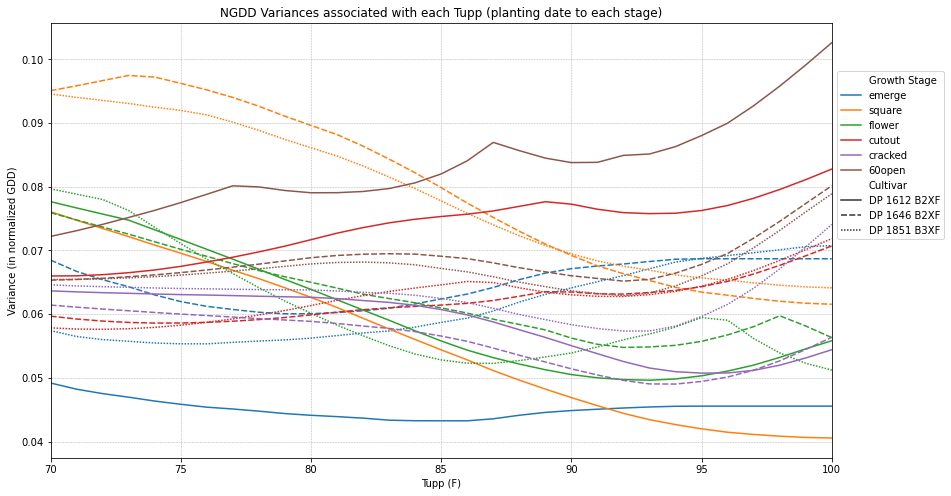

In [194]:
# Create a plot of all normalized GDD variances, for all clusters and growth stages, against Tupp
fig,ax = plt.subplots(1,figsize=(14,8))

sns.lineplot(x='tupp',y='var_normgdd',style='Cultivar',hue='Growth Stage',hue_order=list(stages_all),
                  data=gdd_normalized_tupps.rename(columns={'cultivar':'Cultivar','stage':'Growth Stage'}),ax=ax)
ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
ax.set_xlabel("Tupp (F)")
plt.xticks(np.arange(tupp_min, tupp_max+1, 5))
plt.xlim([tupp_min,tupp_max])

ax.set_title("NGDD Variances associated with each Tupp (planting date to each stage)")
ax.set_ylabel("Variance (in normalized GDD)")
plt.grid(linestyle='--',linewidth=0.5)

plt.show();

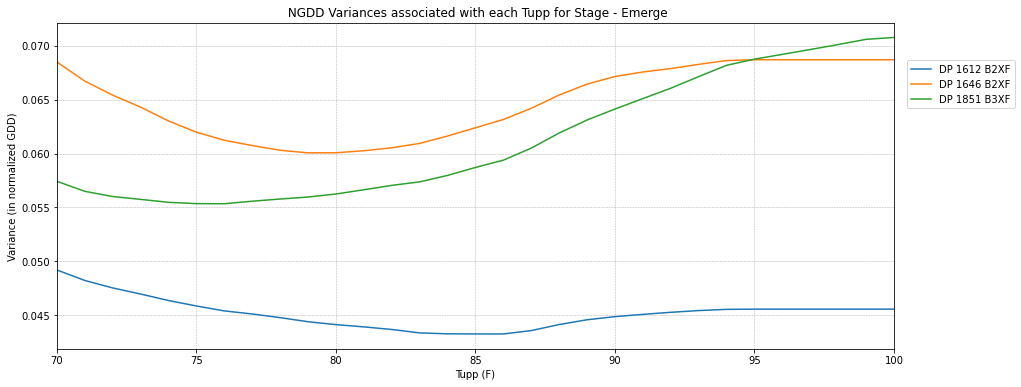

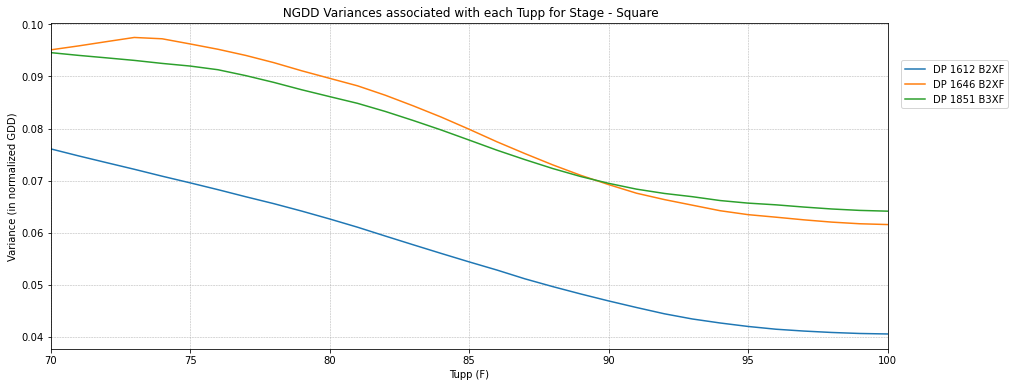

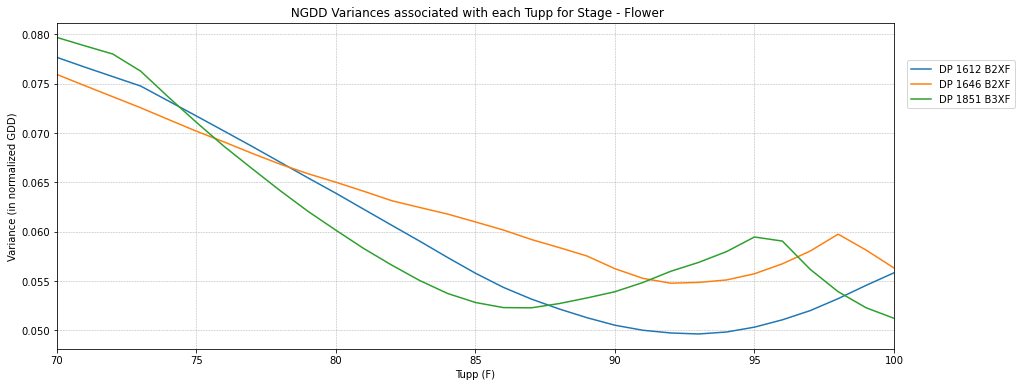

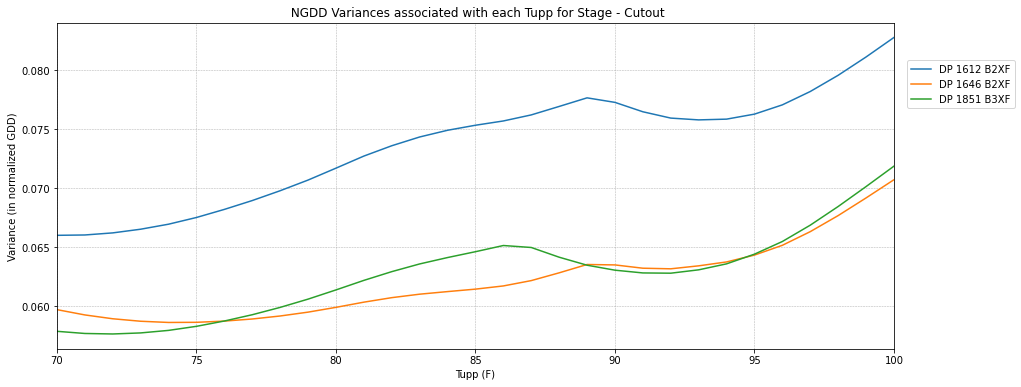

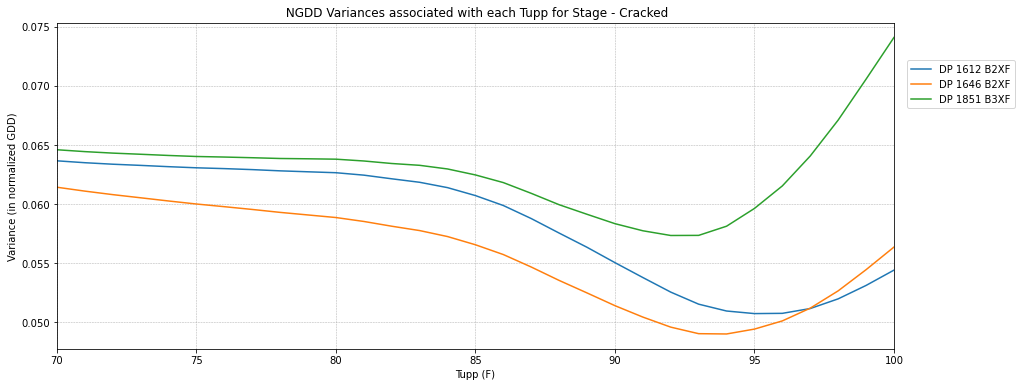

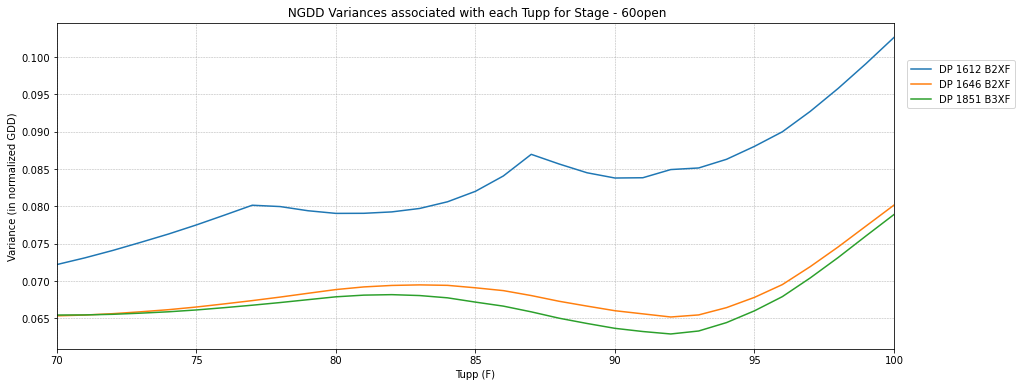

,Cultivar,Stage,Tupp,GDD_Threshold,MinTemp_Search,MaxTemp_Search
0,DP 1612 B2XF,emerge,86,94.336250,70,100
1,DP 1646 B2XF,emerge,79,76.336250,70,100
2,DP 1851 B3XF,emerge,76,65.896250,70,100
3,DP 1612 B2XF,square,100,625.742500,70,100
4,DP 1646 B2XF,square,100,625.742500,70,100
5,DP 1851 B3XF,square,100,625.742500,70,100
6,DP 1612 B2XF,flower,93,1072.490000,70,96
7,DP 1646 B2XF,flower,92,1062.608750,70,96
8,DP 1851 B3XF,flower,87,979.170000,70,96
9,DP 1612 B2XF,cutout,93,1565.301563,89,100


In [195]:
stage_tupp_opt = []

for s in range(len(stages_all)):

    fig,ax = plt.subplots(1,figsize=(15,6))

    sns.lineplot(x='tupp',y='var_normgdd',hue='cultivar',
                  data=gdd_normalized_tupps[gdd_normalized_tupps['stage']==stages_all[s]],ax=ax)

    ax.set_title(" NGDD Variances associated with each Tupp for Stage - " + stages_all[s].capitalize())
    ax.set_ylabel("Variance (in normalized GDD)")
    ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
    ax.set_xlabel("Tupp (F)")
    plt.xticks(np.arange(tupp_min, tupp_max+1, 5))
    plt.xlim([tupp_min,tupp_max])

    plt.grid(linestyle='--',linewidth=0.5)
    plt.show()
    
    # Print out the tupp with minimum variance (looking between 70 and 100 to start)
    min_F = tupp_min
    max_F = tupp_max
    if(stages_all[s]=='flower'):
        max_F = 96
    if(stages_all[s]=='cutout'):
        min_F = 89
    if(stages_all[s]=='60open'):
        min_F = 87
    cultivars = gdd_normalized_tupps.cultivar.unique()
    for v in range(len(cultivars)):
        
        min_var_val = gdd_normalized_tupps[(gdd_normalized_tupps['stage']==stages_all[s]) & 
                              (gdd_normalized_tupps['tupp']>=min_F) &
                              (gdd_normalized_tupps['tupp']<=max_F) &
                              (gdd_normalized_tupps['cultivar']==cultivars[v])]['var_normgdd'].min()
        min_var_tupp = gdd_normalized_tupps[(gdd_normalized_tupps['stage']==stages_all[s]) & 
                              (gdd_normalized_tupps['tupp']>=min_F) &
                              (gdd_normalized_tupps['tupp']<=max_F) &
                              (gdd_normalized_tupps['var_normgdd']==min_var_val) &
                              (gdd_normalized_tupps['cultivar']==cultivars[v])]['tupp'].values[0]
        
        needed_gdd_tupp = gdd_avg_needed_by_stage[(gdd_avg_needed_by_stage['stage']==stages_all[s]) &
                                                   (gdd_avg_needed_by_stage['tupp']==min_var_tupp)
                                                  ]['cum_gdd'].values[0]
        
        stage_tupp_opt.append({'Cultivar':cultivars[v],'Stage':stages_all[s],'Tupp':min_var_tupp,
                               'GDD_Threshold':needed_gdd_tupp,'MinTemp_Search':min_F,'MaxTemp_Search':max_F})

opt_tupp_plantToStage = pd.DataFrame(stage_tupp_opt)
display(opt_tupp_plantToStage)

In [196]:
# Format optimal upper temp table for easier reading and prng
opt_tupp_plantToStage.reset_index()

# Create a numeric column for stages = called stage num
opt_tupp_plantToStage['stage_num'] = opt_tupp_plantToStage['Stage'].map(stage_dict)

# Sort by cultivar, stage
opt_tupp_plantToStage.sort_values(by=['Cultivar','stage_num'],inplace=True)

# Print
display(opt_tupp_plantToStage)

,Cultivar,Stage,Tupp,GDD_Threshold,MinTemp_Search,MaxTemp_Search,stage_num
0,DP 1612 B2XF,emerge,86,94.336250,70,100,1
3,DP 1612 B2XF,square,100,625.742500,70,100,2
6,DP 1612 B2XF,flower,93,1072.490000,70,96,3
9,DP 1612 B2XF,cutout,93,1565.301563,89,100,4
12,DP 1612 B2XF,cracked,95,2133.381250,70,100,5
15,DP 1612 B2XF,60open,90,2305.913750,87,100,6
1,DP 1646 B2XF,emerge,79,76.336250,70,100,1
4,DP 1646 B2XF,square,100,625.742500,70,100,2
7,DP 1646 B2XF,flower,92,1062.608750,70,96,3
10,DP 1646 B2XF,cutout,92,1547.360938,89,100,4


### Create a plot with the distribution of GDDs needed for each stage, based on training set
(do this for 60open only)

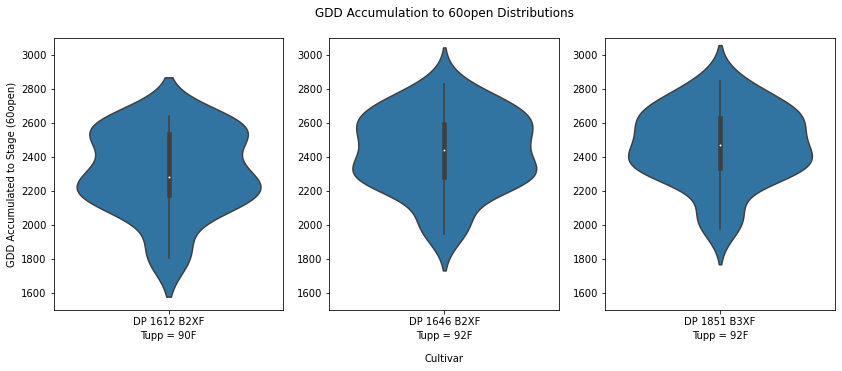

In [197]:
fig,ax = plt.subplots(1,3,figsize=(14,5))

for v in range(3):
    tupp_curr = opt_tupp_plantToStage[(opt_tupp_plantToStage['Cultivar']==cultivars[v]) &
                                (opt_tupp_plantToStage['Stage']=='60open')]['Tupp'].values[0]

    sns.violinplot(x='cultivar',y='cum_gdd',
        data=gdd_by_tupp[(gdd_by_tupp['cultivar']==cultivars[v]) & (gdd_by_tupp['stage']=='60open') &
                                (gdd_by_tupp['tupp']==tupp_curr)],
                  ax=ax[v])
    ax[v].set_ylim([1500,3100])
    xlabel_str = 'Tupp = '+str(tupp_curr)+'F'
    ylabel_str = ''
    if v == 0:
        ylabel_str = 'GDD Accumulated to Stage (60open)'
    if v == 1:
        xlabel_str = xlabel_str+'\n\nCultivar'
    ax[v].set_xlabel(xlabel_str)
    ax[v].set_ylabel(ylabel_str)

ax[1].set_title('GDD Accumulation to 60open Distributions\n');


In [198]:
vald_df_fullseas = getPredObs_DaysToStage(opt_tupp_plantToStage,growth_pd[growth_pd['test_train']==0].copy(),wxdf,'from_plant')

vald_df_fullseas.groupby(['cultivar','stage_num'])['Obs-Pred'].describe()

count      mean        std   min   25%  50%    75%  \
cultivar     stage_num                                                       
DP 1612 B2XF 1           48.0 -2.062500   4.269667 -11.0 -3.00 -1.0   0.00   
             2           48.0 -1.354167  11.187930 -25.0 -5.25 -0.5   5.25   
             3           48.0 -3.645833  11.250512 -32.0 -6.00 -2.0   3.25   
             4           48.0 -4.062500   8.114621 -20.0 -9.75 -1.0   3.00   
             5           48.0 -2.645833  11.904745 -29.0 -7.00 -1.0   2.25   
             6           44.0 -0.568182  12.714024 -31.0 -8.00 -1.5   7.00   
DP 1646 B2XF 1           48.0 -1.645833   4.436261 -12.0 -2.00 -1.0   0.25   
             2           48.0  2.270833  12.800830 -23.0 -3.00  3.5  12.00   
             3           48.0 -0.083333  12.208879 -30.0 -3.25 -0.5  11.00   
             4           48.0 -1.500000   7.371596 -17.0 -4.75  1.0   4.00   
             5           48.0 -0.562500  13.580189 -29.0 -3.50  0.0   4.25   
             6           44.0  0.204545  14.290311 -32.0 -7.50  1.0   9.00   
DP 1851 B3XF 1           48.0 -2.125000   5.233383 -15.0 -4.00 -1.0   1.25   
             2           48.0  2.770833  12.060556 -21.0 -3.00  5.0  10.25   
             3           48.0  0.937500  11.688158 -26.0 -3.00  2.0  10.25   
             4           48.0 -0.791667   7.534201 -19.0 -4.25  1.5   4.00   
             5           48.0  1.125000  14.780126 -30.0 -2.00  3.0   7.25   
             6           44.0  2.363636  15.093647 -30.0 -3.25  5.0  10.25   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1           4.0  
             2          21.0  
             3          12.0  
             4           8.0  
             5          19.0  
             6          22.0  
DP 1646 B2XF 1           6.0  
             2          24.0  
             3          17.0  
             4           9.0  
             5          30.0  
             6          23.0  
DP 1851 B3XF 1           8.0  
             2          24.0  
             3          18.0  
             4          10.0  
             5          31.0  
             6          26.0

## Repeating empirical method from above, but this time looking at just the between-stages Tupp and GDD requirements

In [199]:
wxdf_copy = wxdf.copy().reset_index()
for tupp in range(tupp_min,tupp_max+1):
    wxdf_copy['gdd_'+str(tupp)] = 0
    wxdf_copy.loc[wxdf_copy['tmean_F']>tupp,'gdd_'+str(tupp)] = wxdf_copy['tmean_F'] - tbase
    
    # If daily Max temp > upper threshold, then set this to (Tupp + Tmin)/2 - tbase
    wxdf_copy.loc[(wxdf_copy['tmmx_F']>tupp) & (wxdf_copy['tmean_F']>tbase),'gdd_'+str(tupp)] =\
        ((wxdf_copy['tmmn_F']+tupp)/2) - tbase

In [200]:
train_data = growth_pd[(growth_pd['test_train']==1)].copy()
train_data.set_index(['loc_id','cultivar','plot'],inplace=True)

In [201]:
# Create an array with all the GDD column names
cum_gdd_cols = ['gdd_'+str(x)+'_cum' for x in range(tupp_min,tupp_max+1)]

In [202]:
arr_gdd_by_tupp = []
for i in set(train_data.index):
    copy_train = train_data.loc[i].copy()
    
    # Get start and end dates corresponding to this location's (loc_id-cultivar-plot) plant date and harvest (60open)
    plant_day = copy_train[copy_train['stage_num']==1]['day_of_year_stage'].values[0] - \
                copy_train[copy_train['stage_num']==1]['elapse_days'].values[0]

    # Iterate through each stage
    for s in range(1,7):
        
        # Get the day of year for the previous growth stage:
        prev_day_year = np.nan
        if s==1:
            prev_day_year = plant_day-1
        else:
            prev_arr = copy_train[copy_train['stage_num']==s-1]['day_of_year_stage'].values
            if len(prev_arr)>0:
                prev_day_year = prev_arr[0]

        # Get current stage day of year:
        stage_day_of_year = np.nan
        stage_day_arr = copy_train[copy_train['stage_num']==s]['day_of_year_stage'].values
        if len(stage_day_arr)>0:
            stage_day_of_year = stage_day_arr[0]

        # If we have both this stage's date AND the last stage's date, we can compute
        if (math.isnan(prev_day_year)==False) & (math.isnan(stage_day_of_year)==False):

            # Get weather data corresponding to just this location-plot 
            gdd_df = wxdf_copy[(wxdf_copy['loc_id']==list(i)[0]) & 
                                  (wxdf_copy['date']>prev_day_year) &
                                  (wxdf_copy['date']<=stage_day_of_year)].copy()

            # Accumulate gdd here
            #gdd_sum_tupp = []
            for tupp in range(tupp_min,tupp_max+1):
                #gdd_sum_tupp.append(gdd_df['gdd_'+str(tupp)].sum())

                gdd_sum_tupp = gdd_df['gdd_'+str(tupp)].sum()
            
                # Currently getting for full season, but want to get for each growth stage
                # also get number of days in season with max temp greater than tupp
                check_start = prev_day_year
                check_end = stage_day_of_year
                ndays_gt_tupp = gdd_df[(gdd_df['date']>check_start) & (gdd_df['date']<=check_end) &
                                 (gdd_df['tmmx_F']>tupp)]['tmmx_F'].count()
                
                # also get number of day sin stage -- so can output n days gt tupp as a percentage
                ndays_gt_tupp_pct = (ndays_gt_tupp / (check_end - check_start)) * 100
            
                arr_gdd_by_tupp.append({'loc_id':list(i)[0],'plot':list(i)[2],'cultivar':list(i)[1],
                             'tupp':tupp,'stage':stages_all[s-1],'cum_gdd':gdd_sum_tupp,
                                        'ndays_gt_tupp':ndays_gt_tupp,'ndays_gt_tupp_pct':ndays_gt_tupp_pct})

In [203]:
# Now compute normalized GDD for each stage
gdd_by_tupp = pd.DataFrame(arr_gdd_by_tupp)
gdd_by_tupp['max_ngdd_all'] = gdd_by_tupp.groupby(by=['cultivar','stage','tupp'])['cum_gdd'].transform('max')
gdd_by_tupp['min_ngdd_all'] = gdd_by_tupp.groupby(by=['cultivar','stage','tupp'])['cum_gdd'].transform('min')

gdd_by_tupp['norm_gdd'] = (gdd_by_tupp['cum_gdd'] - gdd_by_tupp['min_ngdd_all'])/ \
                           (gdd_by_tupp['max_ngdd_all'] - gdd_by_tupp['min_ngdd_all'])

In [204]:
# Create "vectors" of normalized GDD by each cultivar, stage, and Tupp
gdd_normalized_tupps = pd.DataFrame(gdd_by_tupp.groupby(['cultivar','stage','tupp']).norm_gdd.var().reset_index())
gdd_normalized_tupps.rename(columns={'norm_gdd':'var_normgdd'},inplace=True)

In [205]:
# # Going to try to add an average across locations of the number of days in each season above tupp
gdd_normalized_tupps['mean_ndays_gt_tupp'] = pd.DataFrame(gdd_by_tupp.groupby(['cultivar','stage','tupp'])
                                                        .ndays_gt_tupp.mean()).reset_index().ndays_gt_tupp

gdd_normalized_tupps['mean_pctndays_gt_tupp'] = pd.DataFrame(gdd_by_tupp.groupby(['cultivar','stage','tupp'])
                                                        .ndays_gt_tupp_pct.mean()).reset_index().ndays_gt_tupp_pct


In [206]:
# Compute the average GDD accumulation by cultivar-stage-Tupp (will output the one that "matches" optimal Tupp)
gdd_avg_needed_by_stage = pd.DataFrame(gdd_by_tupp.groupby(['cultivar','stage','tupp']).\
                                       cum_gdd.mean().reset_index())

Text(0, 0, '')


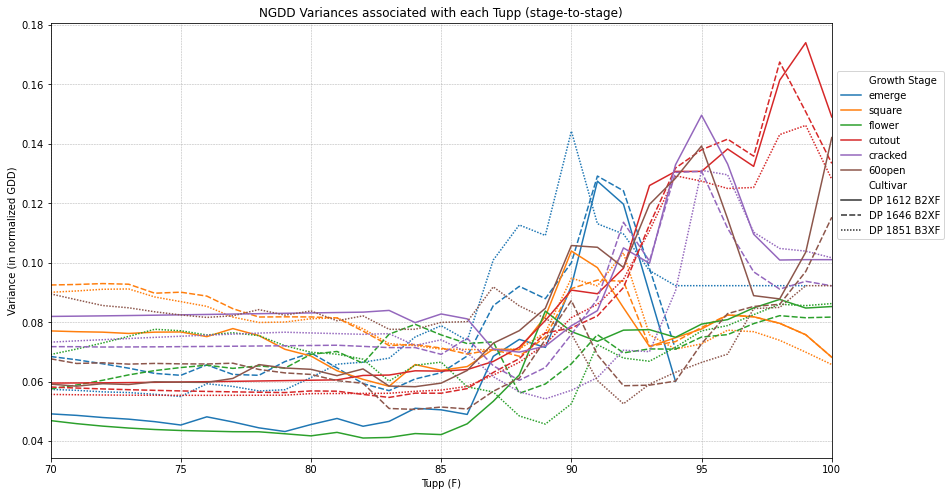

In [207]:
# Create a plot of all normalized GDD variances, for all clusters and growth stages, against Tupp
fig,ax = plt.subplots(1,figsize=(14,8))

sns.lineplot(x='tupp',y='var_normgdd',style='Cultivar',hue='Growth Stage',hue_order=list(stages_all),
                  data=gdd_normalized_tupps.rename(columns={'cultivar':'Cultivar','stage':'Growth Stage'}),ax=ax)
ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
ax.set_xlabel("Tupp (F)")
plt.xticks(np.arange(tupp_min, tupp_max+1, 5))
plt.xlim([tupp_min,tupp_max])

ax.set_title("NGDD Variances associated with each Tupp (stage-to-stage)")
ax.set_ylabel("Variance (in normalized GDD)")
plt.grid(linestyle='--',linewidth=0.5)

print(ax.get_legend().get_title())
plt.show();

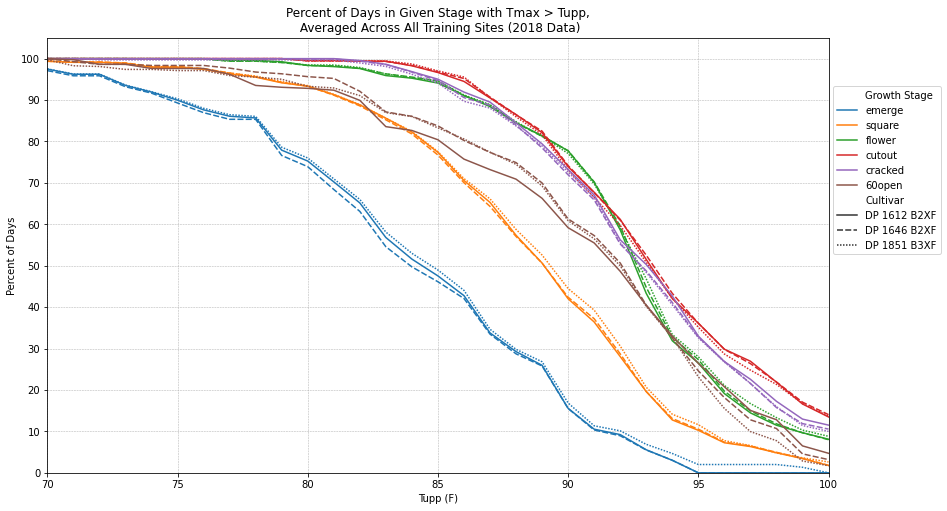

In [208]:
# Create a plot of all normalized GDD variances, for all clusters and growth stages, against Tupp
fig,ax = plt.subplots(1,figsize=(14,8))

sns.lineplot(x='tupp',y='mean_pctndays_gt_tupp',style='Cultivar',hue='Growth Stage',hue_order=list(stages_all),
                  data=gdd_normalized_tupps.rename(columns={'cultivar':'Cultivar','stage':'Growth Stage'}),ax=ax)
ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
ax.set_xlabel("Tupp (F)")
plt.xticks(np.arange(tupp_min, tupp_max+1, 5))
plt.xlim([tupp_min,tupp_max])

plt.yticks(np.arange(0, 101, 10))
plt.ylim([0,105])



ax.set_title("Percent of Days in Given Stage with Tmax > Tupp,\n Averaged Across All Training Sites (2018 Data)")
ax.set_ylabel("Percent of Days")
plt.grid(linestyle='--',linewidth=0.5)

plt.show();

In [209]:
# create a dataframe that contains the tupp corresponding to when ~50% of max temps > tupp
# This will be the max temperature to search within the min variances to determine optimal tupp
tupp_max_thresh = gdd_normalized_tupps.loc[gdd_normalized_tupps[
    gdd_normalized_tupps['mean_pctndays_gt_tupp']>=50].groupby(
    ['cultivar','stage']).mean_pctndays_gt_tupp.idxmin()]

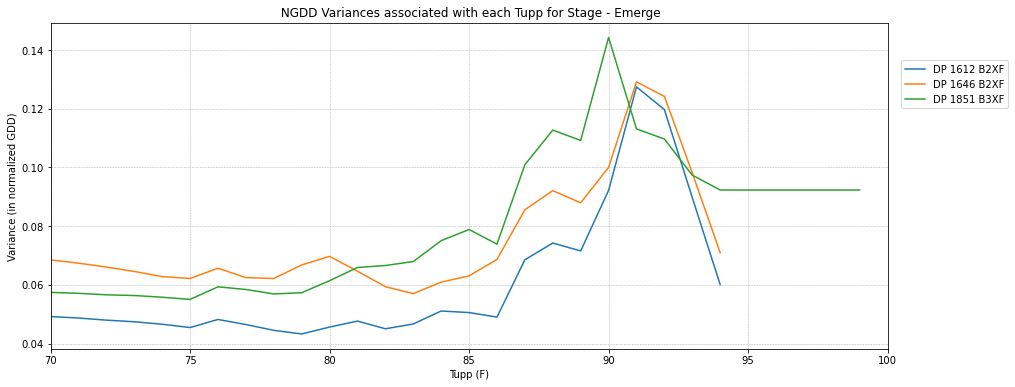

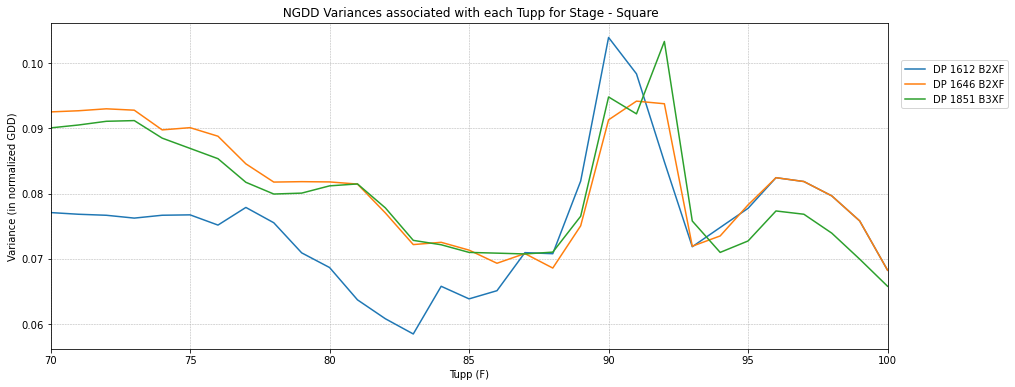

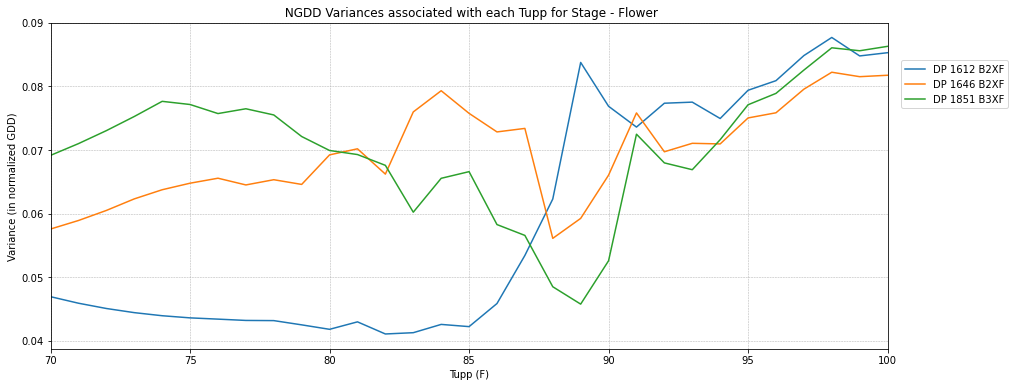

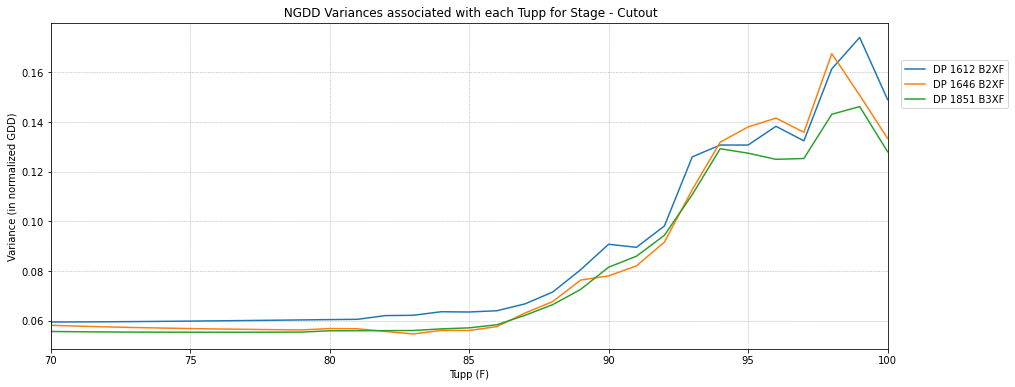

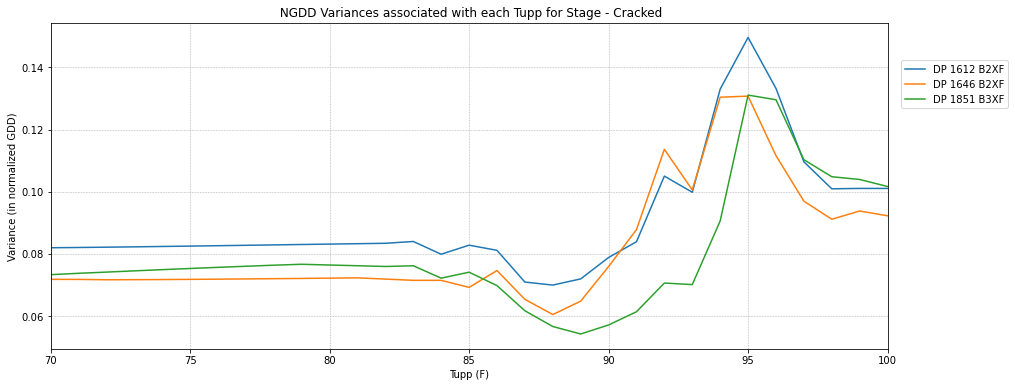

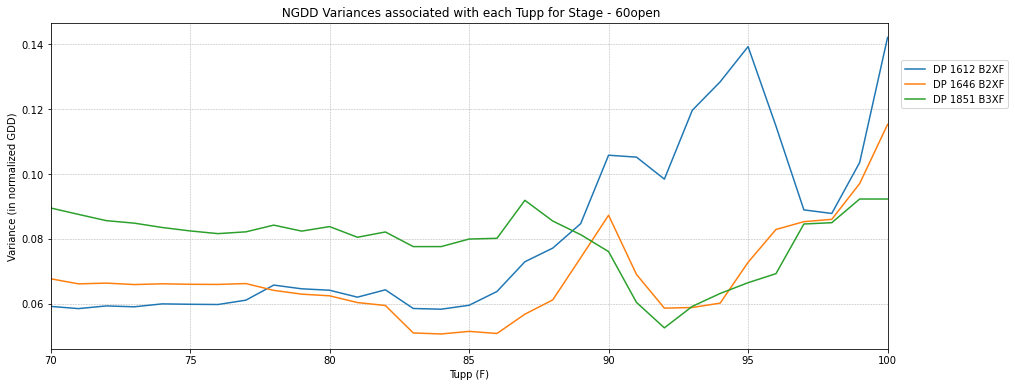

In [210]:
stage_tupp_opt = []

for s in range(len(stages_all)):

    fig,ax = plt.subplots(1,figsize=(15,6))

    sns.lineplot(x='tupp',y='var_normgdd',hue='cultivar',
                  data=gdd_normalized_tupps[gdd_normalized_tupps['stage']==stages_all[s]],ax=ax)

    ax.set_title(" NGDD Variances associated with each Tupp for Stage - " + stages_all[s].capitalize())
    ax.set_ylabel("Variance (in normalized GDD)")
    ax.legend(bbox_to_anchor=(0.65, 0, 0.5, 0.9))
    ax.set_xlabel("Tupp (F)")
    plt.xticks(np.arange(tupp_min, tupp_max+1, 5))
    plt.xlim([tupp_min,tupp_max])

    plt.grid(linestyle='--',linewidth=0.5)
    plt.show()
    
    
    # Print out the tupp with minimum variance (looking between 70 and 100 for now)
    min_F = 70
    max_F = 100
    cultivars = gdd_normalized_tupps.cultivar.unique()
    for v in range(len(cultivars)):
        if(stages_all[s]=='emerge'):
            min_F = 76
            max_F = 85
        if(stages_all[s]=='square'):
            min_F = 76
            max_F = 90
        if(stages_all[s]=='flower'):
            min_F = 80
            max_F = 90
        if(stages_all[s]=='cracked'):
            min_F = 85
            max_F = 95
        if(stages_all[s]=='60open'):
            if cultivars[v]=='DP 1612 B2XF':
                min_F = 83
                max_F = 90 
            else:
                min_F = 90
                max_F = 95 

        # Get max_F to use for search - is based on Tupp at which fewer than 50% of days exceed tupp (i.e.,
        # we only want to search when there are in fact days where temperature gets above tupp)
        max_F = tupp_max_thresh[(tupp_max_thresh['cultivar']==cultivars[v]) &
                                (tupp_max_thresh['stage']==stages_all[s])]['tupp'].values[0]
        
        min_var_val = gdd_normalized_tupps[(gdd_normalized_tupps['stage']==stages_all[s]) & 
                              (gdd_normalized_tupps['tupp']>=min_F) &
                              (gdd_normalized_tupps['tupp']<=max_F) &
                              (gdd_normalized_tupps['cultivar']==cultivars[v])]['var_normgdd'].min()
        min_var_tupp = gdd_normalized_tupps[(gdd_normalized_tupps['stage']==stages_all[s]) & 
                              (gdd_normalized_tupps['tupp']>=min_F) &
                              (gdd_normalized_tupps['tupp']<=max_F) &
                              (gdd_normalized_tupps['var_normgdd']==min_var_val) &
                              (gdd_normalized_tupps['cultivar']==cultivars[v])]['tupp'].values[0]
        
        needed_gdd_tupp = gdd_avg_needed_by_stage[(gdd_avg_needed_by_stage['stage']==stages_all[s]) &
                                                   (gdd_avg_needed_by_stage['tupp']==min_var_tupp)
                                                  ]['cum_gdd'].values[0]
        
        stage_tupp_opt.append({'Cultivar':cultivars[v],'Stage':stages_all[s],'Tupp':min_var_tupp,
                               'GDD_Threshold':needed_gdd_tupp,'MinTemp_Search':min_F,'MaxTemp_Search':max_F})

opt_tupp_stageToStage = pd.DataFrame(stage_tupp_opt)

In [211]:
# Format optimal base temp table for easier reading and prng
opt_tupp_stageToStage.reset_index()

# Create a numeric column for stages = called stage num
opt_tupp_stageToStage['stage_num'] = opt_tupp_stageToStage['Stage'].map(stage_dict)

# Sort by cultivar, stage
opt_tupp_stageToStage.sort_values(by=['Cultivar','stage_num'],inplace=True)

# Print
display(opt_tupp_stageToStage)

,Cultivar,Stage,Tupp,GDD_Threshold,MinTemp_Search,MaxTemp_Search,stage_num
0,DP 1612 B2XF,emerge,79,67.281250,76,84,1
3,DP 1612 B2XF,square,83,382.408750,76,89,2
6,DP 1612 B2XF,flower,82,347.218750,80,92,3
9,DP 1612 B2XF,cutout,70,253.020313,70,93,4
12,DP 1612 B2XF,cracked,88,402.509375,85,93,5
15,DP 1612 B2XF,60open,84,219.703750,83,91,6
1,DP 1646 B2XF,emerge,83,60.523750,76,83,1
4,DP 1646 B2XF,square,88,300.862500,76,89,2
7,DP 1646 B2XF,flower,88,360.432500,80,92,3
10,DP 1646 B2XF,cutout,83,403.335938,70,93,4


In [212]:
stageeach_vald_df = getPredObs_DaysToStage(
    opt_tupp_stageToStage,growth_pd[growth_pd['test_train']==0].copy(),wxdf,'each')

stageeach_vald_df.groupby(['cultivar','stage_num'])['Obs-Pred'].describe()

count       mean       std   min   25%   50%    75%  \
cultivar     stage_num                                                        
DP 1612 B2XF 1           48.0  -1.229167  4.283762 -11.0 -1.00   0.0   1.00   
             2           48.0   0.875000  7.063918 -12.0 -4.25   2.0   5.00   
             3           48.0  -3.291667  5.283287 -13.0 -7.00  -4.0   0.00   
             4           48.0  -0.666667  5.125378 -13.0 -3.25  -1.0   2.00   
             5           48.0   7.083333  6.906159  -7.0  3.75   7.0  11.50   
             6           48.0   2.312500  5.403530  -7.0 -2.25   1.5   6.25   
DP 1646 B2XF 1           48.0   0.854167  3.940999  -8.0  1.00   1.0   3.00   
             2           48.0  12.000000  7.718450  -4.0  5.75  11.5  18.00   
             3           48.0  -0.687500  5.371938 -12.0 -4.50   0.0   3.00   
             4           48.0  -0.916667  6.661523 -12.0 -6.00  -1.0   3.00   
             5           48.0   6.854167  8.482747 -11.0  2.00   5.0  12.25   
             6           48.0   7.375000  6.420131  -1.0  1.75   6.0  11.50   
DP 1851 B3XF 1           48.0  -1.291667  4.644642 -12.0 -2.00  -1.0   1.25   
             2           48.0  10.062500  7.039119  -7.0  6.00  10.5  14.00   
             3           48.0   0.083333  4.770625 -10.0 -4.00   0.0   3.25   
             4           48.0  -1.729167  5.945639 -12.0 -6.00  -2.0   2.25   
             5           48.0   9.666667  9.347507  -9.0  5.00   8.5  14.00   
             6           48.0   6.791667  7.088974  -8.0  1.75   4.0  13.25   

                         max  
cultivar     stage_num        
DP 1612 B2XF 1           5.0  
             2          18.0  
             3           8.0  
             4          12.0  
             5          20.0  
             6          14.0  
DP 1646 B2XF 1           8.0  
             2          27.0  
             3           9.0  
             4          14.0  
             5          28.0  
             6          21.0  
DP 1851 B3XF 1           9.0  
             2          24.0  
             3          11.0  
             4           8.0  
             5          29.0  
             6          18.0

In [213]:
with pd.ExcelWriter('OutputFiles/UpperTemp_ThresholdsPredictions.xlsx') as writer:  
                
        opt_tupp_plantToStage.round(2).to_excel(writer,sheet_name='FullSeason_Thresholds')
    
        opt_tupp_stageToStage.round(2).to_excel(writer,sheet_name='StageOnly_Thresholds')
    
    
        vald_df_fullseas.groupby(['cultivar','stage_num'])['Obs-Pred'].describe().round(2)\
                .to_excel(writer,sheet_name='FullSeason_Predictions')

        stageeach_vald_df.groupby(['cultivar','stage_num'])['Obs-Pred'].describe().round(2)\
                .to_excel(writer,sheet_name='StageOnly_Predictions')